In [1]:
from argparse import ArgumentParser
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import os
import time
import sys
import pandas as pd
import itertools
from src.modules import DenoisingHead # rename modules to models
from src.train_test import run
from src.utils import *

pd.set_option('display.max_rows', None)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [2]:
parser = ArgumentParser()
config, _ = parser.parse_known_args()

In [3]:
config.model = 'denoising'
config.output_attentions = True
config.output_hidden_states = True
config.vocab_size = 271 # Time samples
config.hidden_size = 256
config.max_position_embeddings = 20
config.layer_norm_eps = 1e-12
config.hidden_dropout_prob = 0.1
config.num_attention_heads = 4
config.attention_probs_dropout_prob = 0.1
config.intermediate_size = config.hidden_size*4
config.chunk_size_feed_forward = 0
config.num_hidden_layers = 4

In [5]:
# Training Parameter
config.batch_size = 16
config.lr = 5e-4
config.epoch = 200
config.patience = 20

# I/O parameter
config.parent_dir = './results/finetune/denoising/'
config.model_path = './results/pretrain/'
config.dataset = './data/finetune/'

In [6]:
train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

In [7]:
idx = torch.randint(len(test_data), (2,)) # accounting for batch

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['labels'][idx]

labels[0,:,:].shape

torch.Size([20, 271])

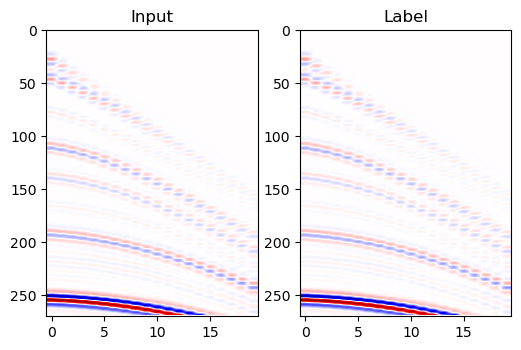

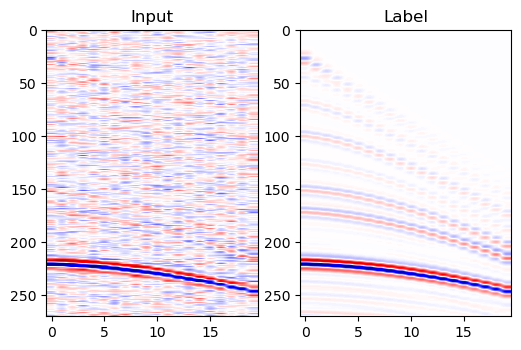

In [8]:
for i in range(len(idx)):
    fig, ax = plt.subplots(1, 2, figsize=(6, 5))
    ax[0].imshow(inputs_embeds[i, :, :].swapaxes(0, 1) - inputs_embeds[i, :, :].mean(), aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
    ax[0].set_title("Input")
    ax[1].imshow(labels[i, :, :].swapaxes(0, 1) - labels[i, :, :].mean(), aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
    ax[1].set_title("Label")

In [9]:
train_dataloader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=config.batch_size, shuffle=True)

## Setup Seismic denoising model

In [10]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

### Load pre-trained model

In [11]:
model = torch.load(os.path.join(config.model_path, "model.pt"))

model.cls = DenoisingHead(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_f

In [12]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

In [13]:
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_f

In [14]:
model, avg_train_loss, avg_test_loss, epoch_count = run(model, train_dataloader, test_dataloader, device, config)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.016141 | Average Test Loss: 0.009838  
Validation loss decreased (inf --> 0.009838)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.008106 | Average Test Loss: 0.006233  
Validation loss decreased (0.009838 --> 0.006233)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.005384 | Average Test Loss: 0.004016  
Validation loss decreased (0.006233 --> 0.004016)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.003790 | Average Test Loss: 0.002794  
Validation loss decreased (0.004016 --> 0.002794)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.002787 | Average Test Loss: 0.001977  
Validation loss decreased (0.002794 --> 0.001977)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.002129 | Average Test Loss: 0.001502  
Validation loss decreased (0.001977 --> 0.001502)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.001751 | Average Test Loss: 0.001249  
Validation loss decreased (0.001502 --> 0.001249)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.001514 | Average Test Loss: 0.001090  
Validation loss decreased (0.001249 --> 0.001090)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.001348 | Average Test Loss: 0.000979  
Validation loss decreased (0.001090 --> 0.000979)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.001226 | Average Test Loss: 0.000912  
Validation loss decreased (0.000979 --> 0.000912)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.001124 | Average Test Loss: 0.000860  
Validation loss decreased (0.000912 --> 0.000860)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.001051 | Average Test Loss: 0.000807  
Validation loss decreased (0.000860 --> 0.000807)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000985 | Average Test Loss: 0.000779  
Validation loss decreased (0.000807 --> 0.000779)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000927 | Average Test Loss: 0.000750  
Validation loss decreased (0.000779 --> 0.000750)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000879 | Average Test Loss: 0.000731  
Validation loss decreased (0.000750 --> 0.000731)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000839 | Average Test Loss: 0.000713  
Validation loss decreased (0.000731 --> 0.000713)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000800 | Average Test Loss: 0.000702  
Validation loss decreased (0.000713 --> 0.000702)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000768 | Average Test Loss: 0.000695  
Validation loss decreased (0.000702 --> 0.000695)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000741 | Average Test Loss: 0.000670  
Validation loss decreased (0.000695 --> 0.000670)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000715 | Average Test Loss: 0.000657  
Validation loss decreased (0.000670 --> 0.000657)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000692 | Average Test Loss: 0.000665  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000670 | Average Test Loss: 0.000653  
Validation loss decreased (0.000657 --> 0.000653)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000653 | Average Test Loss: 0.000636  
Validation loss decreased (0.000653 --> 0.000636)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000635 | Average Test Loss: 0.000635  
Validation loss decreased (0.000636 --> 0.000635)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000618 | Average Test Loss: 0.000630  
Validation loss decreased (0.000635 --> 0.000630)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000602 | Average Test Loss: 0.000621  
Validation loss decreased (0.000630 --> 0.000621)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000589 | Average Test Loss: 0.000618  
Validation loss decreased (0.000621 --> 0.000618)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000576 | Average Test Loss: 0.000623  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000561 | Average Test Loss: 0.000613  
Validation loss decreased (0.000618 --> 0.000613)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000550 | Average Test Loss: 0.000604  
Validation loss decreased (0.000613 --> 0.000604)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000540 | Average Test Loss: 0.000609  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000529 | Average Test Loss: 0.000608  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000521 | Average Test Loss: 0.000600  
Validation loss decreased (0.000604 --> 0.000600)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000512 | Average Test Loss: 0.000608  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000505 | Average Test Loss: 0.000601  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000496 | Average Test Loss: 0.000593  
Validation loss decreased (0.000600 --> 0.000593)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000488 | Average Test Loss: 0.000588  
Validation loss decreased (0.000593 --> 0.000588)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000479 | Average Test Loss: 0.000591  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000473 | Average Test Loss: 0.000584  
Validation loss decreased (0.000588 --> 0.000584)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000467 | Average Test Loss: 0.000589  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000463 | Average Test Loss: 0.000580  
Validation loss decreased (0.000584 --> 0.000580)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000458 | Average Test Loss: 0.000589  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000450 | Average Test Loss: 0.000589  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000443 | Average Test Loss: 0.000581  
EarlyStopping counter: 3 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000439 | Average Test Loss: 0.000581  
EarlyStopping counter: 4 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000435 | Average Test Loss: 0.000580  
EarlyStopping counter: 5 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000430 | Average Test Loss: 0.000579  
Validation loss decreased (0.000580 --> 0.000579)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000425 | Average Test Loss: 0.000586  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000420 | Average Test Loss: 0.000581  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000418 | Average Test Loss: 0.000577  
Validation loss decreased (0.000579 --> 0.000577)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000412 | Average Test Loss: 0.000578  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000407 | Average Test Loss: 0.000576  
Validation loss decreased (0.000577 --> 0.000576)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000405 | Average Test Loss: 0.000573  
Validation loss decreased (0.000576 --> 0.000573)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000399 | Average Test Loss: 0.000567  
Validation loss decreased (0.000573 --> 0.000567)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000396 | Average Test Loss: 0.000577  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000394 | Average Test Loss: 0.000578  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000388 | Average Test Loss: 0.000575  
EarlyStopping counter: 3 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000385 | Average Test Loss: 0.000573  
EarlyStopping counter: 4 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000383 | Average Test Loss: 0.000562  
Validation loss decreased (0.000567 --> 0.000562)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000379 | Average Test Loss: 0.000572  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000376 | Average Test Loss: 0.000566  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000374 | Average Test Loss: 0.000573  
EarlyStopping counter: 3 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000371 | Average Test Loss: 0.000579  
EarlyStopping counter: 4 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000369 | Average Test Loss: 0.000567  
EarlyStopping counter: 5 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000366 | Average Test Loss: 0.000571  
EarlyStopping counter: 6 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000363 | Average Test Loss: 0.000566  
EarlyStopping counter: 7 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000357 | Average Test Loss: 0.000564  
EarlyStopping counter: 8 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000355 | Average Test Loss: 0.000559  
Validation loss decreased (0.000562 --> 0.000559)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000356 | Average Test Loss: 0.000570  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000349 | Average Test Loss: 0.000573  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000351 | Average Test Loss: 0.000561  
EarlyStopping counter: 3 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000349 | Average Test Loss: 0.000572  
EarlyStopping counter: 4 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000347 | Average Test Loss: 0.000564  
EarlyStopping counter: 5 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000343 | Average Test Loss: 0.000571  
EarlyStopping counter: 6 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000341 | Average Test Loss: 0.000558  
Validation loss decreased (0.000559 --> 0.000558)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000337 | Average Test Loss: 0.000564  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000335 | Average Test Loss: 0.000570  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000332 | Average Test Loss: 0.000560  
EarlyStopping counter: 3 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000331 | Average Test Loss: 0.000567  
EarlyStopping counter: 4 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000331 | Average Test Loss: 0.000560  
EarlyStopping counter: 5 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000328 | Average Test Loss: 0.000558  
Validation loss decreased (0.000558 --> 0.000558)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000328 | Average Test Loss: 0.000562  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000324 | Average Test Loss: 0.000558  
Validation loss decreased (0.000558 --> 0.000558)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000324 | Average Test Loss: 0.000555  
Validation loss decreased (0.000558 --> 0.000555)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000323 | Average Test Loss: 0.000569  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000321 | Average Test Loss: 0.000564  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000317 | Average Test Loss: 0.000551  
Validation loss decreased (0.000555 --> 0.000551)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000318 | Average Test Loss: 0.000567  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000317 | Average Test Loss: 0.000560  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000315 | Average Test Loss: 0.000570  
EarlyStopping counter: 3 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000313 | Average Test Loss: 0.000562  
EarlyStopping counter: 4 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000311 | Average Test Loss: 0.000554  
EarlyStopping counter: 5 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000309 | Average Test Loss: 0.000556  
EarlyStopping counter: 6 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000308 | Average Test Loss: 0.000561  
EarlyStopping counter: 7 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000305 | Average Test Loss: 0.000558  
EarlyStopping counter: 8 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000306 | Average Test Loss: 0.000555  
EarlyStopping counter: 9 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000304 | Average Test Loss: 0.000558  
EarlyStopping counter: 10 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000303 | Average Test Loss: 0.000581  
EarlyStopping counter: 11 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000303 | Average Test Loss: 0.000558  
EarlyStopping counter: 12 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000299 | Average Test Loss: 0.000561  
EarlyStopping counter: 13 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000299 | Average Test Loss: 0.000564  
EarlyStopping counter: 14 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000297 | Average Test Loss: 0.000562  
EarlyStopping counter: 15 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000296 | Average Test Loss: 0.000556  
EarlyStopping counter: 16 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000292 | Average Test Loss: 0.000551  
Validation loss decreased (0.000551 --> 0.000551)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000295 | Average Test Loss: 0.000562  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000292 | Average Test Loss: 0.000561  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000292 | Average Test Loss: 0.000565  
EarlyStopping counter: 3 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000290 | Average Test Loss: 0.000558  
EarlyStopping counter: 4 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000289 | Average Test Loss: 0.000565  
EarlyStopping counter: 5 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000288 | Average Test Loss: 0.000553  
EarlyStopping counter: 6 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000287 | Average Test Loss: 0.000564  
EarlyStopping counter: 7 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000286 | Average Test Loss: 0.000552  
EarlyStopping counter: 8 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000286 | Average Test Loss: 0.000564  
EarlyStopping counter: 9 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000283 | Average Test Loss: 0.000567  
EarlyStopping counter: 10 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000283 | Average Test Loss: 0.000561  
EarlyStopping counter: 11 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000282 | Average Test Loss: 0.000553  
EarlyStopping counter: 12 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000281 | Average Test Loss: 0.000554  
EarlyStopping counter: 13 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000279 | Average Test Loss: 0.000557  
EarlyStopping counter: 14 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000279 | Average Test Loss: 0.000561  
EarlyStopping counter: 15 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000278 | Average Test Loss: 0.000555  
EarlyStopping counter: 16 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000277 | Average Test Loss: 0.000549  
Validation loss decreased (0.000551 --> 0.000549)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000274 | Average Test Loss: 0.000556  
EarlyStopping counter: 1 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000275 | Average Test Loss: 0.000557  
EarlyStopping counter: 2 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000276 | Average Test Loss: 0.000556  
EarlyStopping counter: 3 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000273 | Average Test Loss: 0.000557  
EarlyStopping counter: 4 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000272 | Average Test Loss: 0.000557  
EarlyStopping counter: 5 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000271 | Average Test Loss: 0.000549  
EarlyStopping counter: 6 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000272 | Average Test Loss: 0.000557  
EarlyStopping counter: 7 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000271 | Average Test Loss: 0.000564  
EarlyStopping counter: 8 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000269 | Average Test Loss: 0.000568  
EarlyStopping counter: 9 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000272 | Average Test Loss: 0.000557  
EarlyStopping counter: 10 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000269 | Average Test Loss: 0.000561  
EarlyStopping counter: 11 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000268 | Average Test Loss: 0.000562  
EarlyStopping counter: 12 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000267 | Average Test Loss: 0.000556  
EarlyStopping counter: 13 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000266 | Average Test Loss: 0.000553  
EarlyStopping counter: 14 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000266 | Average Test Loss: 0.000549  
EarlyStopping counter: 15 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000267 | Average Test Loss: 0.000562  
EarlyStopping counter: 16 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000266 | Average Test Loss: 0.000551  
EarlyStopping counter: 17 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000263 | Average Test Loss: 0.000553  
EarlyStopping counter: 18 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000263 | Average Test Loss: 0.000565  
EarlyStopping counter: 19 out of 20
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 0.000263 | Average Test Loss: 0.000558  
EarlyStopping counter: 20 out of 20
Early stopping


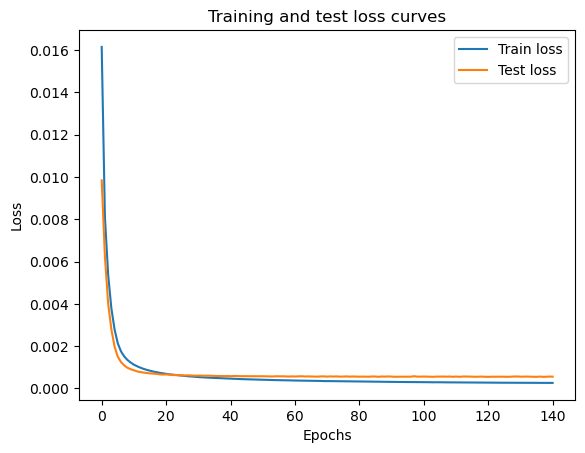

In [15]:
def plot_loss(epoch_count, train_loss, test_loss):
    # Plot Test and Train Loss
    plt.plot(epoch_count[:200], train_loss[:200], label="Train loss")
    plt.plot(epoch_count[:200], test_loss[:200], label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    #plt.savefig('loss.png');

plot_loss(epoch_count, avg_train_loss, avg_test_loss)

In [16]:
x0 = 0.14 # Near offset
dx = 0.09 # Offset increment
dt = 0.008 # Time step

tensor([271, 203])


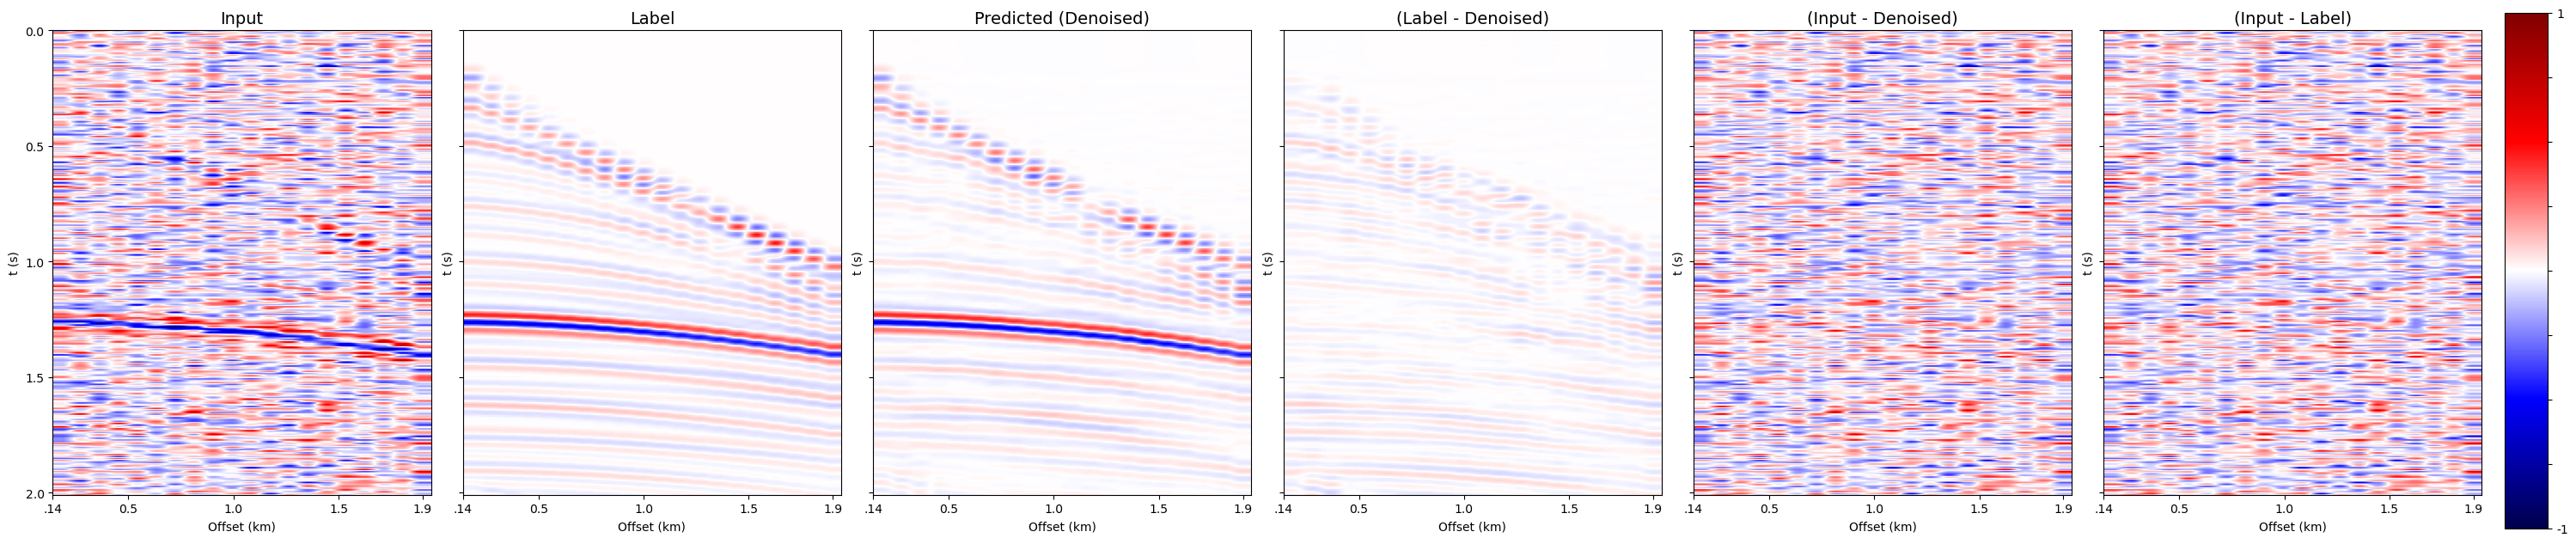

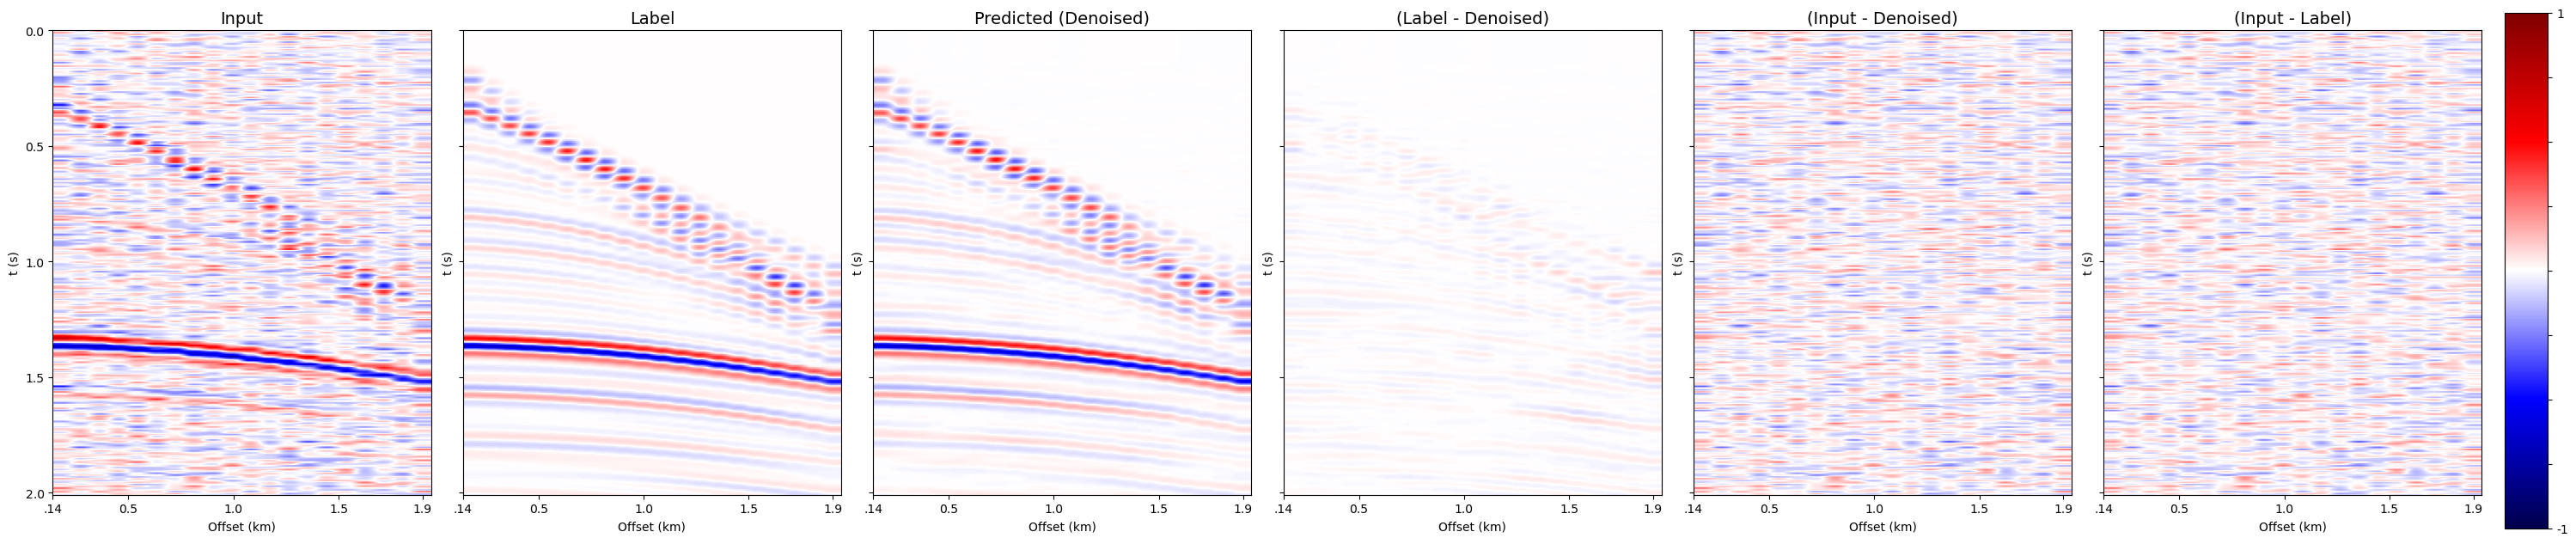

In [18]:
model.eval()

idx = torch.randint(len(test_data), (2,))
print(idx)

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['labels'][idx]
with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device).float())

for X, y, z in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels.cpu()):
    fig, ax = plt.subplots(1, 6, figsize=(29, 7.5), sharey=True, sharex=False)
    fig.tight_layout()
    ax[0].imshow(1 * (X - X.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic', extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0].set_title("Input", fontsize=14)
    ax[0].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0].set_xlabel("Offset (km)")
    ax[0].set_ylabel("t (s)")
    ax[1].imshow(1 * (z - z.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic', extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[1].set_title("Label", fontsize=14)
    ax[1].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[1].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[1].set_yticks(np.arange(0, 2.5, 0.5))
    ax[1].set_xlabel("Offset (km)")
    ax[1].set_ylabel("t (s)")
    ax[2].imshow((y - y.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic', extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[2].set_title("Predicted (Denoised)", fontsize=14)
    ax[2].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[2].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[2].set_yticks(np.arange(0, 2.5, 0.5))
    ax[2].set_xlabel("Offset (km)")
    ax[2].set_ylabel("t (s)")
    label_denoised_diff = (z - y)
    im4 = ax[3].imshow((label_denoised_diff - label_denoised_diff.mean()).detach().swapaxes(0, 1), aspect=1.1, vmin=-1, vmax=1, cmap='seismic', extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[3].set_title("(Label - Denoised)", fontsize=14)
    ax[3].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[3].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[3].set_yticks(np.arange(0, 2.5, 0.5))
    ax[3].set_xlabel("Offset (km)")
    ax[3].set_ylabel("t (s)")
    input_denoised_diff = (X - y)
    ax[4].imshow((input_denoised_diff - input_denoised_diff.mean()).detach().swapaxes(0, 1), aspect=1.1, vmin=-1, vmax=1, cmap='seismic', extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[4].set_title("(Input - Denoised)", fontsize=14)
    ax[4].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[4].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[4].set_yticks(np.arange(0, 2.5, 0.5))
    ax[4].set_xlabel("Offset (km)")
    ax[4].set_ylabel("t (s)")
    input_label_diff = (X - z)
    ax[5].imshow((input_label_diff - input_label_diff.mean()).detach().swapaxes(0, 1), aspect=1.1, vmin=-1, vmax=1, cmap='seismic', extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[5].set_title("(Input - Label)", fontsize=14)
    ax[5].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[5].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[5].set_yticks(np.arange(0, 2.5, 0.5))
    ax[5].set_xlabel("Offset (km)")
    ax[5].set_ylabel("t (s)")
    
    plt.ylim(2.01, 0)

    cbar_ax = fig.add_axes([1, 0.1, 0.0175, 0.8])
    cbar = fig.colorbar(im4, cax=cbar_ax)
    cbar.set_ticks(np.arange(-1, 1.25, .25))
    cbar.set_ticklabels([-1, "", "", "", "", "", "", "", 1])

In [19]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_test_loss_arr = np.array(avg_test_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'test_loss.npy'), avg_test_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_test_loss_arr = np.array(avg_test_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'test_loss.npy'), avg_test_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./results/finetune/denoising/
Saved successfully to ./results/finetune/denoising/
